In [123]:
import pandas as pd
import numpy as np
import geopandas as gp
from unidecode import unidecode
from sklearn.cluster import AgglomerativeClustering as agglcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Argentinian provinces that make up 85% of its wheat production
relevant_areas = ['Buenos Aires', 'Córdoba', 'Entre Ríos', 'La Pampa', 'Santa Fe']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Read Shapefiles 

- gdf_adm1: state level
- gdf_adm2: municipality level

In [124]:
# Read ADM1 shapefiles and filter by relevant provinces
gdf_adm1_raw = gp.read_file("data/shapefile/arg_admbnda_adm1_unhcr2017.shp")
gdf_adm1 = gdf_adm1_raw.loc[gdf_adm1_raw["ADM1_ES"].isin(relevant_areas), ["ADM1_ES", "geometry"]].reset_index(drop=True)
gdf_adm1 = gdf_adm1.to_crs("EPSG:4326")
gdf_adm1_raw = gdf_adm1_raw.to_crs("EPSG:4326")

# Read ADM2 shapefiles and filter by relevant provinces
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2 = gdf_adm2.sjoin(gdf_adm1, how="inner", predicate="intersects")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES_left"] = gdf_adm2["ADM1_ES_left"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES_left"] + " " + gdf_adm2["ADM2_ES"]
gdf_adm2 = gdf_adm2[["name", "geometry"]].reset_index(drop=True)

## 2. Read historical wheat data

- on province level 
- merge with gdf_adm2 to obtain polygon shape for each region

In [125]:
wheat = pd.read_csv("data/crop/province_yield_with_trend.csv", encoding="latin-1")
wheat["province"] = wheat["province"].str.lower().apply(lambda x: unidecode(x))
wheat["municipality"] = wheat["municipality"].str.lower().apply(lambda x: unidecode(x))
wheat["name"] = wheat["province"] + " " + wheat["municipality"]

# Merge with shapefiles to filter relevant departments
wheat = wheat.merge(gdf_adm2[["geometry", "name"]], on="name", how="left").dropna().drop_duplicates()

wheat.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha],name,geometry
0,1969,buenos aires,25 de mayo,42000,71400,1700,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
1,1970,buenos aires,25 de mayo,36000,54000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
2,1971,buenos aires,25 de mayo,30000,39000,1300,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
3,1972,buenos aires,25 de mayo,41000,73600,1795,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
4,1973,buenos aires,25 de mayo,6000,9000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."


#### Plot map

- color municipalities that are part of this study
- because they are part of the five states that contribute mainly to argentinian wheat production..
- ..and because they have a complete yield time series

<Axes: >

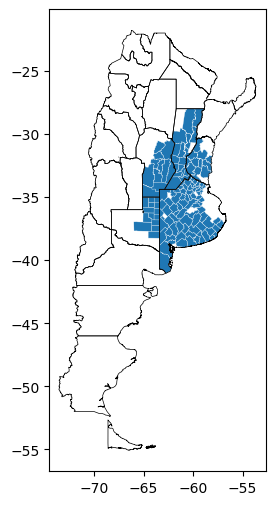

In [126]:
name_filter = wheat["name"].unique().tolist()
gdf_adm2_temp = gdf_adm2.copy()

gdf_adm2_temp["complete_yield_series"] = gdf_adm2_temp["name"].apply(lambda x: "yes" if x in name_filter else "no")
gdf_adm2_temp = gdf_adm2_temp.loc[gdf_adm2_temp["complete_yield_series"] == "yes"].reset_index(drop=True)

base = gdf_adm2_temp.plot(figsize=(6,6), column="complete_yield_series", edgecolor="white", linewidth=.2)
gdf_adm1_raw.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

## 3. Filter ERA by coordinates

In [127]:
era = pd.read_csv("data/ERA/era_complete.csv")
era = gp.GeoDataFrame(era, geometry=gp.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))
era_coordinates = era.groupby(["lat", "lon"]).agg({"geometry":"first"}).reset_index()
era_coordinates = gp.GeoDataFrame(era_coordinates, geometry="geometry", crs="EPSG:4326")
era_coordinates = gp.sjoin(era_coordinates, gdf_adm2_temp).reset_index(drop=True)[["lat", "lon", "geometry", "name"]]
era = era_coordinates[["lat", "lon", "name"]].merge(era, left_on=["lat", "lon"], right_on=["lat", "lon"], how="left")
era.head()
#era_filtered = era.loc[era["month"].between(5,11)]

,lat,lon,name,time,rain,tmean,month,year,geometry
0,-40.9,-62.8,buenos aires patagones,1968-01-01 00:00:00,0.000623,20.971094,1,1968,POINT (-62.80000 -40.90000)
1,-40.9,-62.8,buenos aires patagones,1968-02-01 00:00:00,0.000731,21.416162,2,1968,POINT (-62.80000 -40.90000)
2,-40.9,-62.8,buenos aires patagones,1968-03-01 00:00:00,0.001365,17.787500,3,1968,POINT (-62.80000 -40.90000)
3,-40.9,-62.8,buenos aires patagones,1968-04-01 00:00:00,0.000269,14.364648,4,1968,POINT (-62.80000 -40.90000)
4,-40.9,-62.8,buenos aires patagones,1968-05-01 00:00:00,0.000249,12.334131,5,1968,POINT (-62.80000 -40.90000)


<Axes: >

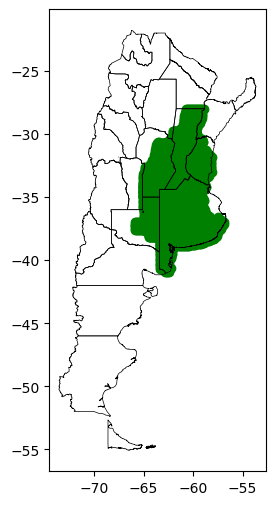

In [128]:
base = era_coordinates.plot(figsize=(6,6), color="green")
gdf_adm1_raw.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

### 4. Determine relevant locations

- averaging tmean and rain across all Argentina is not ideal (area is huge, signal gets lost)
- it is planned to determine 2-4 climate clusters and use the centroids as the locations for the ERA data
- to prevent overfitting we build cluster using data from 1969-1992

In [219]:
wheat.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha],name,geometry
0,1969,buenos aires,25 de mayo,42000,71400,1700,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
1,1970,buenos aires,25 de mayo,36000,54000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
2,1971,buenos aires,25 de mayo,30000,39000,1300,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
3,1972,buenos aires,25 de mayo,41000,73600,1795,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
4,1973,buenos aires,25 de mayo,6000,9000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."


In [227]:
li = []
for area in wheat["name"].unique():
    wheat_area = wheat.loc[(wheat["year"] < 1993) & (wheat["name"] == area), ["year", "yield [kg/ha]", "name", "geometry"]]
    #year_range = wheat.loc[wheat["year"].isin(list(range(year-24, year))), ["year", "yield [kg/ha]"]]
    (slope, bias), (current_error,), *_ = np.polyfit(wheat_area["year"], wheat_area["yield [kg/ha]"], deg=1, full=True)
    wheat_area["yield detrended"] = wheat_area["yield [kg/ha]"] - (wheat_area["year"] * slope + bias)
    li.append(wheat_area)
wheat_filtered_detrended = pd.concat(li, axis=0, ignore_index=True)
wheat_filtered_detrended

,year,yield [kg/ha],name,geometry,yield detrended
0,1969,1700,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",401.923333
1,1970,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",168.089420
2,1971,1300,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",-65.744493
3,1972,1795,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",395.421594
4,1973,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",66.587681
...,...,...,...,...,...
3115,1988,1200,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",-403.075362
3116,1989,1500,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",-136.113188
3117,1990,2045,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",375.848986
3118,1991,1400,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",-302.188841


In [294]:
era_cluster_data = era.loc[(era["year"].isin([1985])) & (era["month"].between(8,11))].reset_index(drop=True).groupby(["name", "year"]).agg({"rain":"mean", "tmean":"mean"}).reset_index()
era_cluster_data = era_cluster_data.merge(gdf_adm2, on="name", how="left").drop_duplicates()
era_cluster_data = gp.GeoDataFrame(era_cluster_data, geometry=era_cluster_data["geometry"], crs="EPSG:4326")
era_cluster_data = era_cluster_data.pivot(index=["name", "geometry"], columns="year", values=["rain", "tmean"]).reset_index()
era_cluster_data.columns = ["{}_{}".format(s[0],s[1]) for s in era_cluster_data.columns]

#scaler = StandardScaler()
#data = era_cluster_data.loc[:, [c for c in era_cluster_data.columns if ("rain" in c)]].transpose()
#data = scaler.fit_transform(data)
#era_cluster_data.loc[:, [c for c in era_cluster_data.columns if ("rain" in c)]] = data.transpose()
#data = era_cluster_data.loc[:, [c for c in era_cluster_data.columns if ("tmean" in c)]].transpose()
#data = scaler.fit_transform(data)
#era_cluster_data.loc[:, [c for c in era_cluster_data.columns if ("tmean" in c)]] = data.transpose()

era_cluster_data = era_cluster_data.rename(columns={"name_":"name", "geometry_":"geometry"})
era_cluster_data = gp.GeoDataFrame(era_cluster_data, geometry="geometry", crs="EPSG:4326")

#era_yield_cluster.head()
wheat_cluster = wheat_filtered_detrended.loc[wheat_filtered_detrended["year"] < 1993].reset_index(drop=True).groupby(["name", "year"]).agg({"yield detrended":"mean"}).reset_index().pivot(index="name", columns="year", values="yield detrended").reset_index()
wheat_cluster = wheat_cluster.merge(gdf_adm2, on="name", how="left").drop_duplicates()

#scaler = StandardScaler()
#data = wheat_cluster.loc[:, [c for c in wheat_cluster.columns if (c != "name") & (c != "geometry")]].transpose()
#data = scaler.fit_transform(data)
#wheat_cluster.loc[:, [c for c in wheat_cluster.columns if (c != "name") & (c != "geometry")]] = data.transpose()
wheat_cluster = gp.GeoDataFrame(wheat_cluster, geometry="geometry", crs="EPSG:4326")
wheat_cluster = wheat_cluster[["name", "geometry",1985]]
wheat_cluster = wheat_cluster.rename(columns={1981:"yield_1981", 1982:"yield_1982", 1984:"yield_1984", 1985:"yield_1985"})

era_yield_cluster = era_cluster_data.merge(wheat_cluster, on=["name", "geometry"])

In [296]:
scaler = StandardScaler()
data = era_yield_cluster.loc[:, ["rain_1985", "tmean_1985", "yield_1985"]].transpose()
data = scaler.fit_transform(data)
era_yield_cluster.loc[:, ["rain_1985", "tmean_1985", "yield_1985"]] = data.transpose()
era_yield_cluster.head()

,name,geometry,rain_1985,tmean_1985,yield_1985
0,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",0.683088,0.730856,-1.413945
1,buenos aires 9 de julio,"POLYGON Z ((-60.84118 -35.16618 0.00000, -60.7...",0.691086,0.723008,-1.414093
2,buenos aires adolfo alsina,"POLYGON Z ((-62.77689 -37.01921 0.00000, -62.6...",-0.383158,1.370516,-0.987358
3,buenos aires adolfo gonzales chaves,"POLYGON Z ((-60.37796 -37.66191 0.00000, -60.4...",0.654299,0.758631,-1.412930
4,buenos aires alberti,"POLYGON Z ((-60.25068 -34.81797 0.00000, -60.2...",0.689430,0.724637,-1.414067


In [136]:
#wheat_area = wheat.loc[wheat["year"] < 1993].groupby(["name", "geometry"]).agg({"harvested area [ha]":"mean"}).reset_index()
#wheat_area = gp.GeoDataFrame(wheat_area, geometry="geometry",  crs="EPSG:4326")
#wheat_area["size"] = wheat_area["geometry"].area

In [137]:
#wheat_area["harvested area [mio. ha]"] = wheat_area["harvested area [ha]"]/1e6
#wheat_area["harvested per size"] = wheat_area["harvested area [mio. ha]"]/wheat_area["size"]
#wheat_area.head()

In [138]:
#wheat_area.sort_values(by="harvested per size", ascending=False).head(10)

In [139]:
#base = wheat_area.plot(figsize=(6,6), column='harvested per size', edgecolor='w', linewidth=0.05)
#gdf_adm1.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

In [297]:
# add NEIGHBORS column
era_yield_cluster["neighbors"] = None  
era_yield_cluster = era_yield_cluster.reset_index(drop=True)

for index, province in era_yield_cluster.iterrows():   
    
    # get 'not disjoint' countries
    neighbors = era_yield_cluster[era_yield_cluster["geometry"].touches(province["geometry"])]["name"].tolist()

    # remove own name of the country from the list
    neighbors = [name for name in neighbors if province["name"] != name]

    # add names of neighbors as NEIGHBORS value
    era_yield_cluster.at[index, "neighbors"] = ", ".join(neighbors)
    
era_yield_cluster["neighbors"] = era_yield_cluster["neighbors"].apply(lambda x: x.split(","))
names_to_neighbours = era_yield_cluster[["name", "neighbors"]].set_index("name").to_dict()["neighbors"]
g = {k: [v.strip() for v in vs] for k, vs in names_to_neighbours.items()}
edges = [(a, b) for a, bs in g.items() for b in bs]

df = pd.DataFrame(edges)

adj_matrix = pd.crosstab(df[0], df[1])

In [298]:
era_yield_cluster.columns

Index(['name', 'geometry', 'rain_1985', 'tmean_1985', 'yield_1985',
       'neighbors'],
      dtype='object')

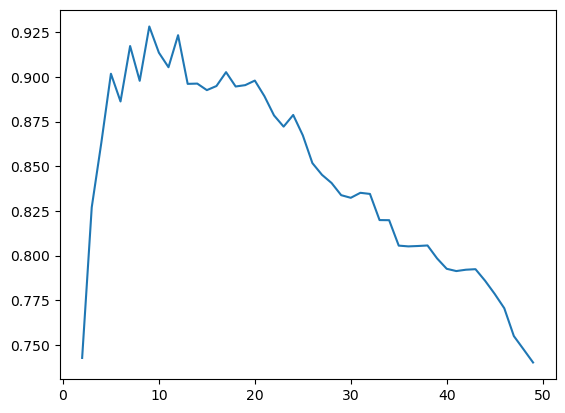

In [299]:
scores = []
for i in range(2,50):
    ward = agglcluster(n_clusters=i, connectivity=adj_matrix, linkage="ward").fit(era_yield_cluster.loc[:, [c for c in era_yield_cluster.columns if c not in ["name", "geometry", "neighbors"]]])
    era_yield_cluster["cluster"] = ward.labels_
    scores.append(silhouette_score(era_yield_cluster.loc[:, [c for c in era_yield_cluster.columns if c not in ["name", "geometry", "neighbors"]]], ward.labels_))
plt.plot(list(range(2,50)), scores);

<Axes: >

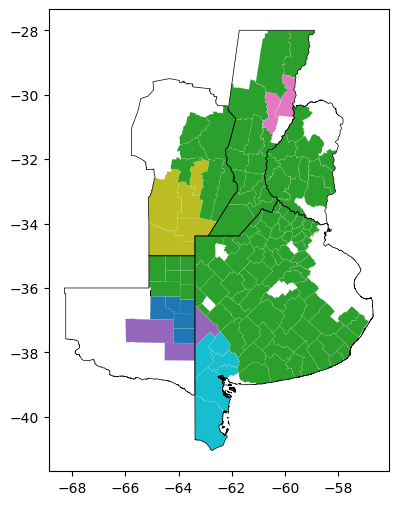

In [306]:
ward = agglcluster(n_clusters=6, connectivity=adj_matrix, linkage="ward").fit(era_yield_cluster.loc[:, [c for c in era_yield_cluster.columns if c not in ["name", "geometry", "neighbors"]]])
era_yield_cluster["cluster"] = ward.labels_
era_yield_cluster = gp.GeoDataFrame(era_yield_cluster, geometry="geometry")
base = era_yield_cluster.plot(figsize=(6,6), column='cluster', categorical=True, edgecolor='w', linewidth=0.05)
gdf_adm1.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

In [205]:
cluster_means = wheat_cluster.groupby(["cluster"])[[c for c in wheat_cluster.columns if c not in ["index", "name", "geometry", "neighbors", "cluster"]]].mean().transpose().to_dict("list")
cluster_means

{0: [1569.9102564102564,
  1712.474358974359,
  1485.320512820513,
  1901.9615384615386,
  1740.3846153846155,
  1762.179487179487,
  1866.5384615384614,
  1819.2051282051282,
  1546.7179487179487,
  2018.4615384615386,
  1869.2307692307693,
  1910.8589743589744,
  1749.1410256410256,
  2324.4871794871797,
  2030.9615384615386,
  2467.6794871794873,
  1515.2692307692307,
  1981.5128205128206,
  1911.4615384615386,
  2124.576923076923,
  2125.730769230769,
  2177.0384615384614,
  2221.871794871795,
  2520.9102564102564],
 1: [943.3461538461538,
  929.3269230769231,
  924.5576923076923,
  1148.4807692307693,
  1477.673076923077,
  1143.1346153846155,
  1479.7307692307693,
  1417.423076923077,
  1043.7884615384614,
  1226.9615384615386,
  1280.326923076923,
  1122.0961538461538,
  1061.8846153846155,
  1605.8653846153845,
  1548.6923076923076,
  2019.5,
  1495.673076923077,
  1343.9615384615386,
  1699.923076923077,
  1449.2692307692307,
  1611.7307692307693,
  1603.0384615384614,
  1893.

In [207]:
wheat_cluster[[c for c in wheat_cluster.columns if c not in ["index", "name", "geometry", "neighbors"]]].iloc[:, :24]

,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992
0,1700.0,1500.0,1300.0,1795.0,1500.0,1500.0,1400.0,1500.0,1203.0,1300.0,...,2000.0,2000.0,1200.0,1786.0,1718.0,1964.0,1878.0,2201.0,2300.0,2601.0
1,1800.0,1592.0,1500.0,1650.0,1707.0,1800.0,1400.0,2000.0,1364.0,1784.0,...,2400.0,2600.0,1300.0,1914.0,1990.0,2500.0,2100.0,2900.0,2800.0,2900.0
2,1300.0,727.0,1200.0,1700.0,1802.0,1200.0,1400.0,1582.0,1100.0,1600.0,...,1800.0,2300.0,1633.0,1792.0,1810.0,1389.0,1810.0,1500.0,1750.0,1399.0
3,1750.0,1389.0,1400.0,1863.0,1799.0,1600.0,1550.0,1760.0,1489.0,2000.0,...,1982.0,2351.0,1700.0,2119.0,1900.0,1492.0,2267.0,1057.0,2422.0,2831.0
4,1700.0,1783.0,1500.0,1700.0,1600.0,2000.0,2000.0,2300.0,1335.0,2100.0,...,2300.0,2100.0,1400.0,2072.0,1994.0,2200.0,2500.0,2900.0,2800.0,2900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,853.0,1405.0,1809.0,1543.0,2100.0,1039.0,2275.0,1900.0,1548.0,1800.0,...,2800.0,2550.0,1737.0,2015.0,1920.0,2000.0,1713.0,1951.0,2500.0,2900.0
126,928.0,1690.0,1156.0,1164.0,1464.0,1156.0,2000.0,1531.0,1467.0,1375.0,...,2000.0,2000.0,1944.0,1500.0,2000.0,1333.0,1308.0,2000.0,2108.0,2600.0
127,1588.0,1889.0,1758.0,1800.0,1933.0,1800.0,2449.0,2382.0,1750.0,2090.0,...,2100.0,2625.0,1691.0,1813.0,2431.0,2242.0,2000.0,2301.0,2200.0,2400.0
128,600.0,895.0,1444.0,1466.0,2352.0,924.0,2305.0,2000.0,1300.0,1889.0,...,2700.0,2700.0,1530.0,1813.0,1878.0,1687.0,1493.0,1950.0,2600.0,2900.0


In [208]:
# compute L2 distance of each municipality to its centroid

wheat_cluster["distance_to_centroid"] = (wheat_cluster[[c for c in wheat_cluster.columns if c not in ["index", "name", "geometry", "neighbors"]]]
                                         .apply(lambda x: np.linalg.norm(cluster_means[x[24]] - x[:24]), axis=1))
wheat_cluster["distance_to_centroid"]

0      1680.106710
1      1581.725281
2      1395.617169
3      1623.703725
4      1532.524561
          ...     
125    1730.275743
126    1902.528776
127    1196.405929
128    2397.035229
129    1441.260217
Name: distance_to_centroid, Length: 130, dtype: float64

In [209]:
cluster_centroids = wheat_cluster.groupby("cluster").agg({"distance_to_centroid":"min"}).reset_index().merge(wheat_cluster[["name", "geometry", "distance_to_centroid"]], on="distance_to_centroid")

<Axes: >

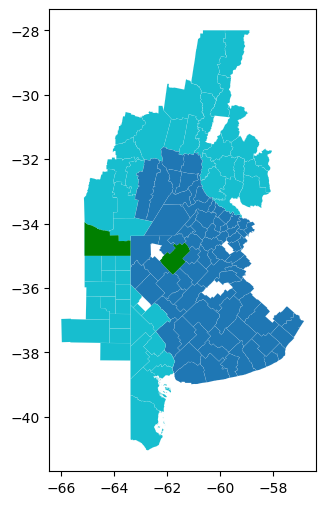

In [210]:
base = wheat_cluster.plot(figsize=(6,6), column='cluster', categorical=True, edgecolor='w', linewidth=0.05)
gp.GeoSeries(cluster_centroids["geometry"]).plot(ax=base, color="green")

C:\Users\Max Zachow\AppData\Local\Temp\ipykernel_8972\500766681.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(data=era_cluster_data, x="tmean", y="rain", hue="cluster", palette=["green", "red", "blue", "orange"])


<Axes: xlabel='tmean', ylabel='rain'>

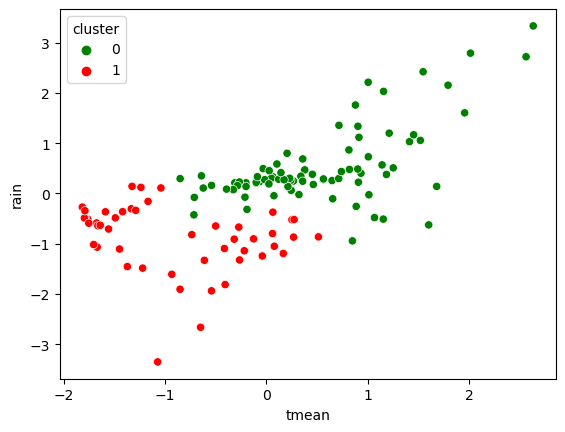

In [101]:
sns.scatterplot(data=era_cluster_data, x="tmean", y="rain", hue="cluster", palette=["green", "red", "blue", "orange"])
#sns.scatterplot(data=cluster_centroids, x="tmean", y="rain", hue="cluster", palette=["green", "red", "blue", "black", "orange"], marker="x")

In [211]:
cluster_centroids

,cluster,distance_to_centroid,name,geometry
0,0,859.924754,buenos aires lincoln,"POLYGON Z ((-61.20562 -34.70166 0.00000, -61.2..."
1,1,1004.002076,cordoba general roca,"POLYGON Z ((-65.11102 -33.95593 0.00000, -65.1..."


In [307]:
era.head()

,lat,lon,name,time,rain,tmean,month,year,geometry
0,-40.9,-62.8,buenos aires patagones,1968-01-01 00:00:00,0.000623,20.971094,1,1968,POINT (-62.80000 -40.90000)
1,-40.9,-62.8,buenos aires patagones,1968-02-01 00:00:00,0.000731,21.416162,2,1968,POINT (-62.80000 -40.90000)
2,-40.9,-62.8,buenos aires patagones,1968-03-01 00:00:00,0.001365,17.787500,3,1968,POINT (-62.80000 -40.90000)
3,-40.9,-62.8,buenos aires patagones,1968-04-01 00:00:00,0.000269,14.364648,4,1968,POINT (-62.80000 -40.90000)
4,-40.9,-62.8,buenos aires patagones,1968-05-01 00:00:00,0.000249,12.334131,5,1968,POINT (-62.80000 -40.90000)


In [214]:
cluster_centroids = gp.GeoDataFrame(cluster_centroids, geometry="geometry", crs="EPSG:4326")
era = gp.GeoDataFrame(era, geometry="geometry", crs="EPSG:4326")
era_filtered = gp.sjoin(era, cluster_centroids[["cluster", "geometry"]]).reset_index(drop=True)
era_filtered.head()

,lat,lon,name,time,rain,tmean,month,year,geometry,index_right,cluster
0,-35.5,-61.8,buenos aires lincoln,1968-01-01 00:00:00,0.003850,22.717188,1,1968,POINT (-61.80000 -35.50000),0,0
1,-35.5,-61.8,buenos aires lincoln,1968-02-01 00:00:00,0.006781,22.396631,2,1968,POINT (-61.80000 -35.50000),0,0
2,-35.5,-61.8,buenos aires lincoln,1968-03-01 00:00:00,0.005609,19.168359,3,1968,POINT (-61.80000 -35.50000),0,0
3,-35.5,-61.8,buenos aires lincoln,1968-04-01 00:00:00,0.000651,14.847070,4,1968,POINT (-61.80000 -35.50000),0,0
4,-35.5,-61.8,buenos aires lincoln,1968-05-01 00:00:00,0.000183,12.414209,5,1968,POINT (-61.80000 -35.50000),0,0


In [311]:
era_filtered = (era
                .loc[(era["year"] >= 1993) & (era["month"].between(8,11))]
                .reset_index(drop=True)
                .groupby(["name", "month", "year"])
                .agg({"rain":"mean", "tmean":"mean"}).reset_index())


#era_filtered = (era
#                .loc[(era["year"] >= 1993) & (era["month"].between(8,11)) & (era["name"].isin(["santa fe caseros", "buenos aires tres arroyos"]))]
#                .reset_index(drop=True)
#                .groupby(["name", "month", "year"])
#                .agg({"rain":"mean", "tmean":"mean"}).reset_index())

In [312]:
era_filtered

,name,month,year,rain,tmean
0,buenos aires 25 de mayo,8,1993,0.001157,10.575532
1,buenos aires 25 de mayo,8,1994,0.000567,10.210426
2,buenos aires 25 de mayo,8,1995,0.000519,9.701277
3,buenos aires 25 de mayo,8,1996,0.003349,12.648936
4,buenos aires 25 de mayo,8,1997,0.002340,11.654681
...,...,...,...,...,...
15595,santa fe vera,11,2018,0.005203,24.444434
15596,santa fe vera,11,2019,0.005835,24.611455
15597,santa fe vera,11,2020,0.003416,24.576133
15598,santa fe vera,11,2021,0.007289,23.318623


In [313]:
weather_features = era_filtered.pivot(index="year", columns=["month", "name"], values=["rain", "tmean"])

weather_features.columns = ["{}_{}_{}".format(s[0],s[1],s[2]) for s in weather_features.columns]

weather_features = weather_features.reset_index()
weather_features.head()

,year,rain_8_buenos aires 25 de mayo,rain_9_buenos aires 25 de mayo,rain_10_buenos aires 25 de mayo,rain_11_buenos aires 25 de mayo,rain_8_buenos aires 9 de julio,rain_9_buenos aires 9 de julio,rain_10_buenos aires 9 de julio,rain_11_buenos aires 9 de julio,rain_8_buenos aires adolfo alsina,...,tmean_10_santa fe san lorenzo,tmean_11_santa fe san lorenzo,tmean_8_santa fe san martin,tmean_9_santa fe san martin,tmean_10_santa fe san martin,tmean_11_santa fe san martin,tmean_8_santa fe vera,tmean_9_santa fe vera,tmean_10_santa fe vera,tmean_11_santa fe vera
0,1993,0.001157,0.003672,0.004624,0.005893,0.001226,0.003883,0.004158,0.006154,0.000183,...,17.6855,19.7475,12.3752,13.8698,18.2698,20.2438,15.30755,16.72310,20.54470,21.86310
1,1994,0.000567,0.004834,0.002982,0.001956,0.001133,0.002992,0.002993,0.001888,0.001488,...,17.3300,21.3690,12.4090,16.6448,18.0072,21.2694,15.09360,19.52820,20.53065,22.21640
2,1995,0.000519,0.000535,0.002790,0.001777,0.000444,0.000537,0.002799,0.002493,0.000266,...,17.0250,21.4455,12.7318,16.6184,17.3464,22.0018,15.98180,18.64765,19.91820,25.47675
3,1996,0.003349,0.001618,0.003890,0.004558,0.002707,0.001404,0.003781,0.003973,0.001928,...,18.5840,21.8340,15.3322,14.7154,18.7960,22.3914,19.00640,17.60870,20.81150,23.38740
4,1997,0.002340,0.001301,0.005324,0.005031,0.001671,0.001263,0.005907,0.004336,0.000586,...,17.7215,20.4600,13.9230,16.1768,18.1366,20.8808,17.67940,19.52105,20.98555,23.19810


In [314]:
weather_features.to_csv("data/weather_features_era.csv", index=False)